## Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier


In [2]:
data_dir = os.path.abspath(os.path.join('..', 'data'))
data = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))
test_data = pd.read_csv(os.path.join(data_dir,'test.csv'))

In [3]:
# Saving test ids to a list to build test subsmissions after model.predict is run
test_ids = test_data["id"].tolist()

## EDA


Missing values after handling:
 Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Waist_Circumference              0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
Fitness_Endurance-Season                  0
Fitness_Endurance-Max_Stage               0
Fitness_Endurance-Time_Mins               0
Fitness_Endurance-Time_Sec                0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_GSND                              0
FGC-FGC_GSND_Zone                         0

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_39723/720159401.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, test_data])
/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_39723/720159401.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original ob

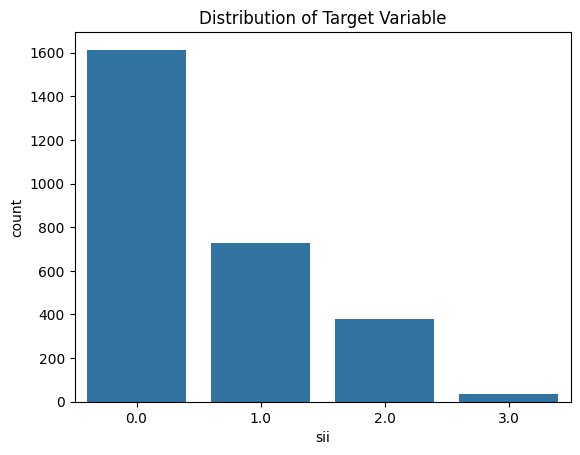

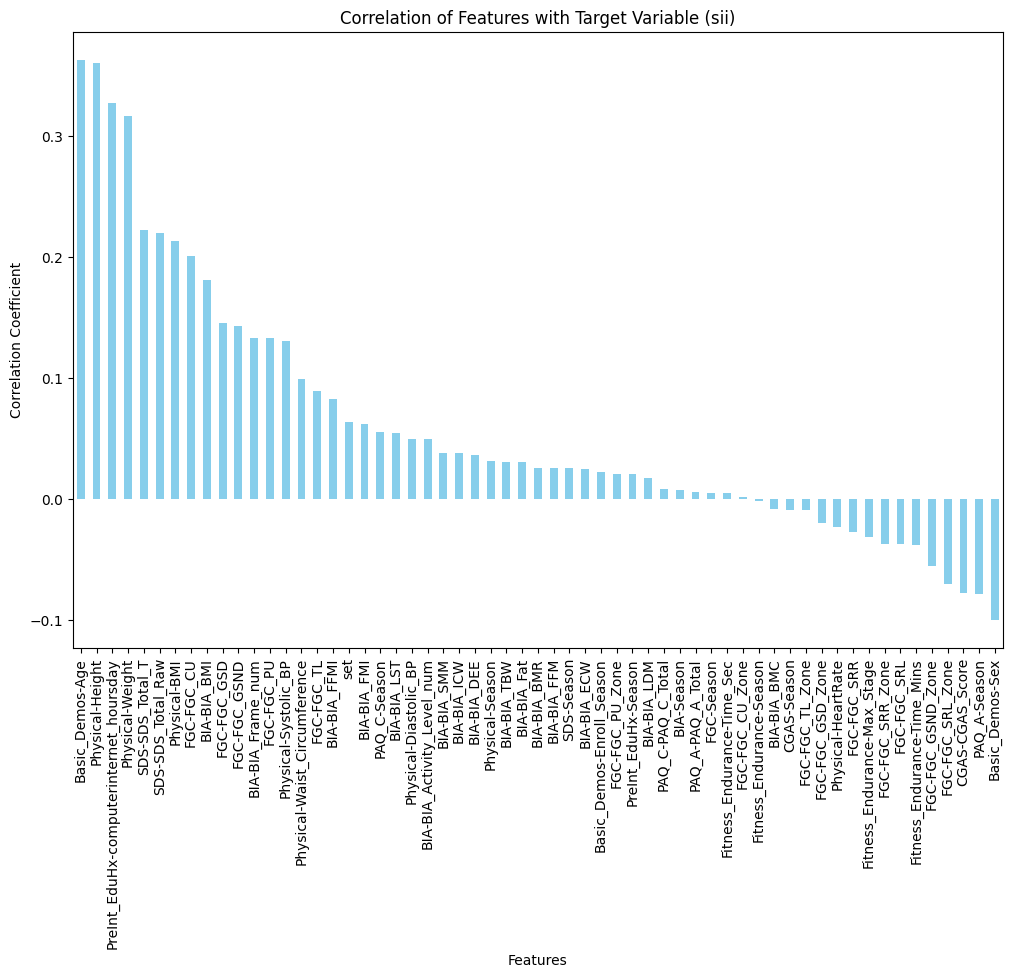

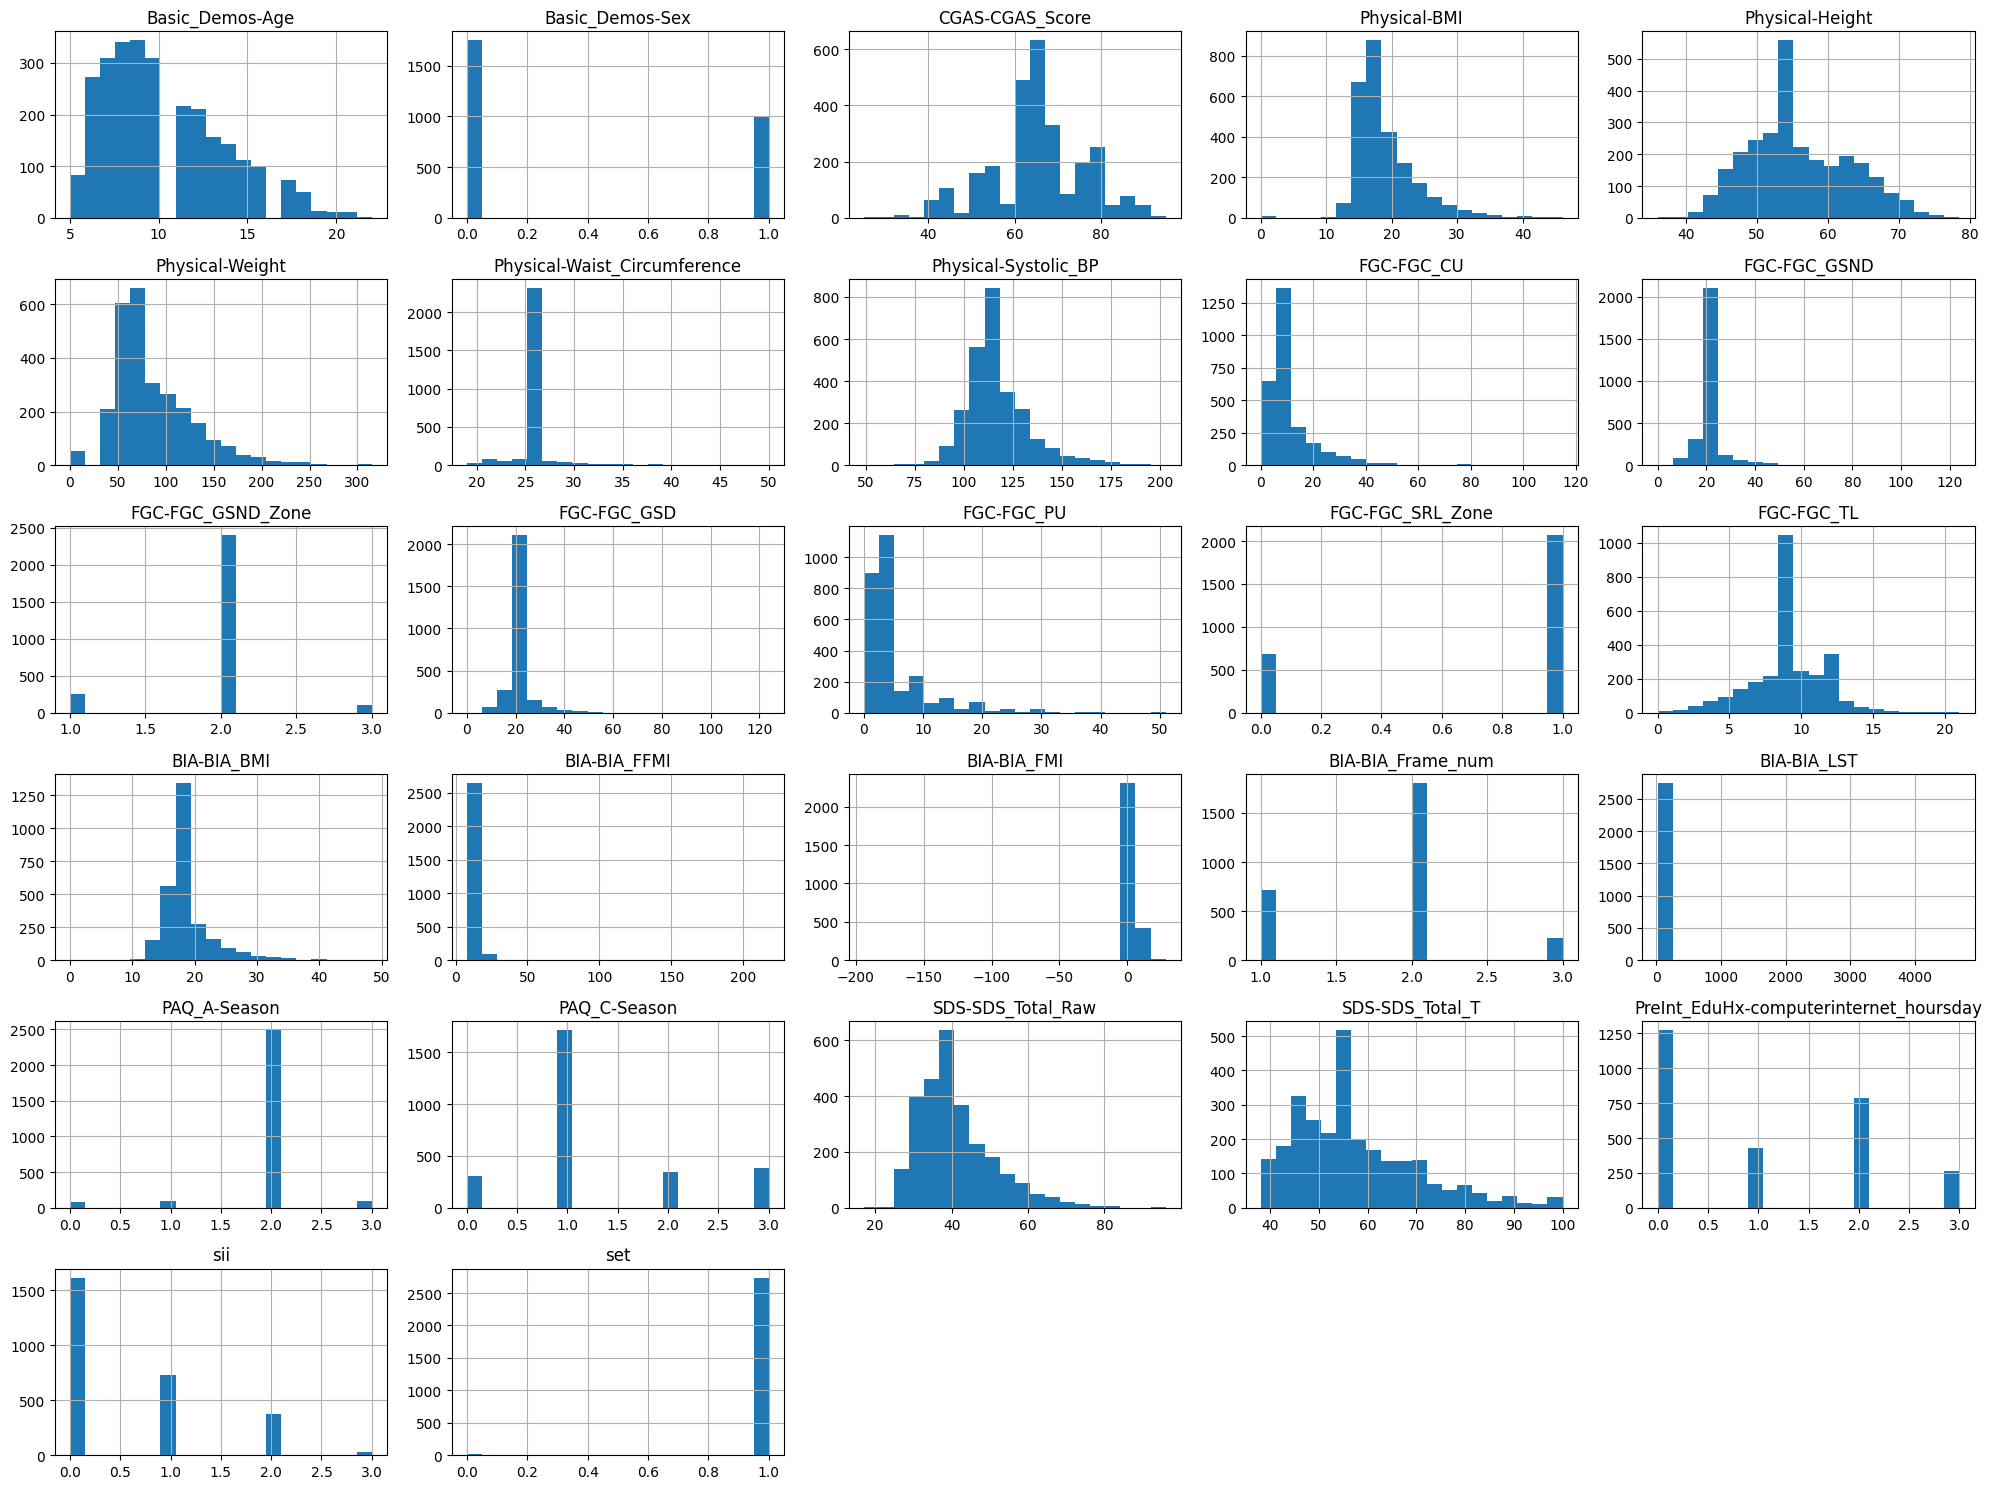

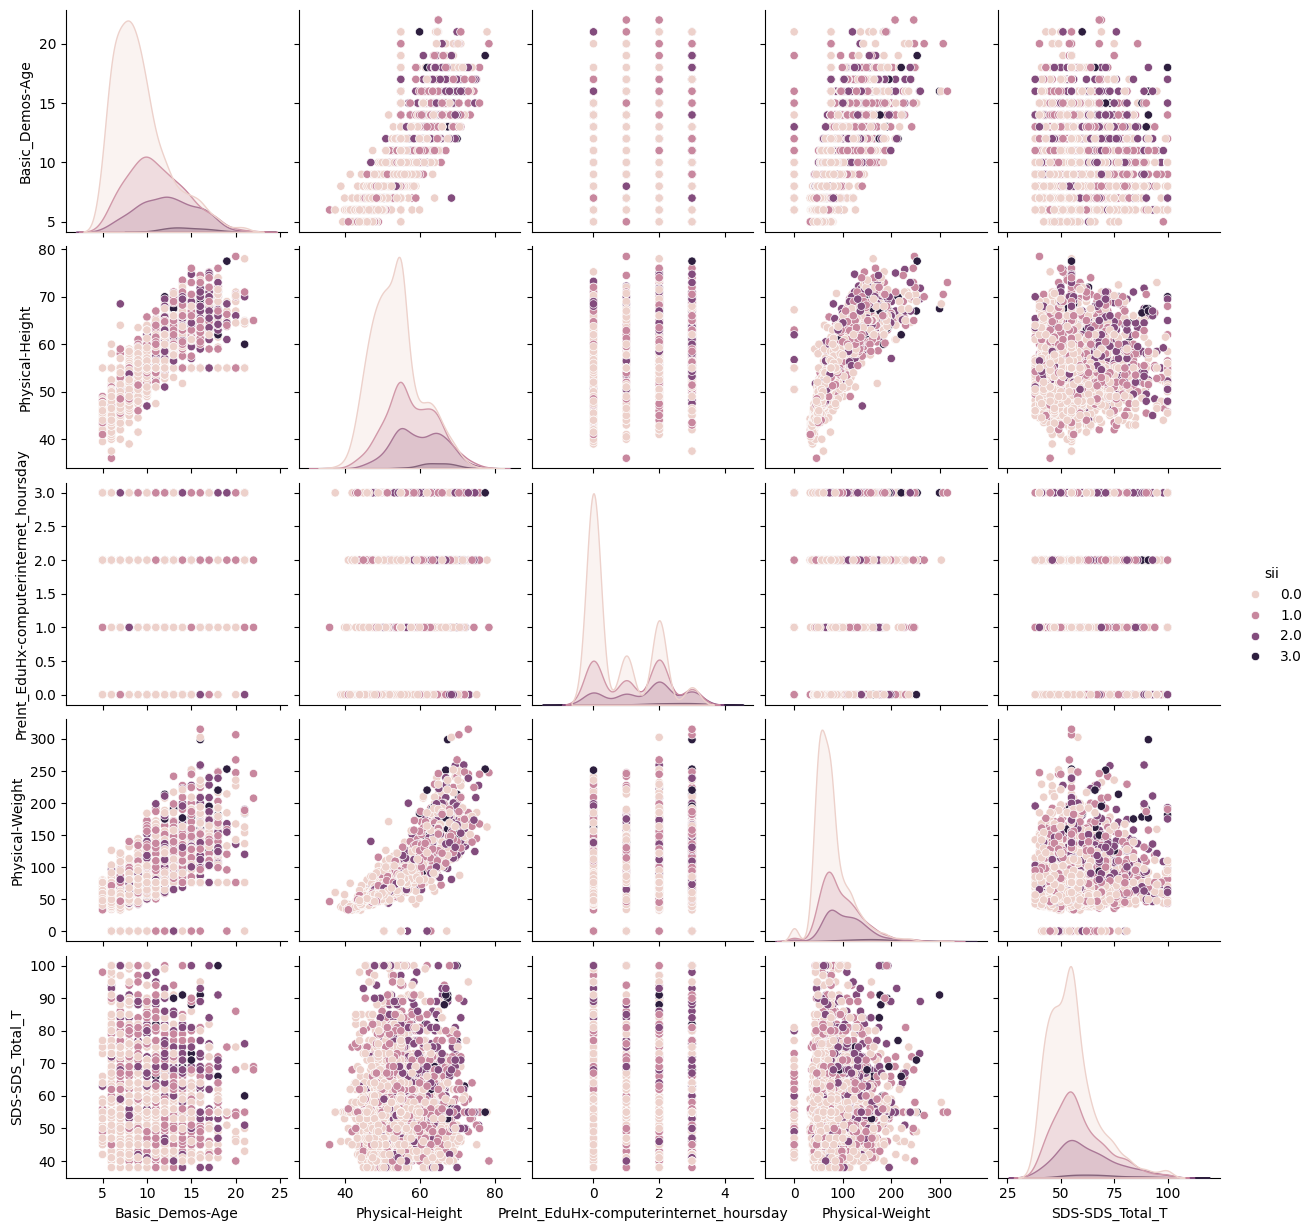

In [4]:
# Step 3: Basic EDA
# Drop the 'id' column if it exists since it is not useful for analysis or modeling
if 'id' in data.columns:
    data = data.drop(columns=['id'])

# Drop PCIAT columns as they are the actual test and answers
drop_columns = [col for col in data.columns if col.startswith('PCIAT')]
data = data.drop(columns=drop_columns)

# Drop rows with missing target values
data = data.dropna(subset=['sii'])

#Appending test_data to data so that it goes through the same data pre-processing
test_data = test_data[data.drop("sii",axis=1).columns]

data["set"] = "train"
test_data["set"] = "test"
test_data["sii"] = None

# Concating train and test together for imputing
data = pd.concat([data, test_data])
data = data.reset_index(drop=True)

# Fill missing values for numerical features with the median
num_features = data.select_dtypes(include=['float64', 'int64']).columns
data[num_features] = data[num_features].fillna(data[num_features].median())

# Fill missing values for categorical features with the mode
cat_features = data.select_dtypes(include=['object']).columns
if len(cat_features) > 0:
    for col in cat_features:
        mode_value = data[col].mode()
        if len(mode_value) > 0:
            data[col].fillna(mode_value.iloc[0], inplace=True)

# Verify that there are no more missing values
print("\nMissing values after handling:\n", data.isnull().sum())

# Convert categorical features to numeric using label encoding for correlation analysis
cat_features = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_features:
    data[col] = le.fit_transform(data[col].astype(str))

# Visualize the distribution of the target variable ('sii')
sns.countplot(x='sii', data=data)
plt.title('Distribution of Target Variable')
plt.show()

# Correlation bar chart of features to 'sii'
correlation = data.corr()['sii'].drop('sii').sort_values(ascending=False)
plt.figure(figsize=(12, 8))
correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target Variable (sii)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

# Drop low correlation features (threshold set at |correlation| < 0.05)
low_correlation_features = correlation[abs(correlation) < 0.05].index
data = data.drop(columns=low_correlation_features)

# Visualize distributions of numerical features
data.hist(bins=20, figsize=(20, 15))
plt.tight_layout()
plt.show()

# Visualize relationships between features and target using pairplot
high_corr_features = correlation[abs(correlation) >= 0.05].index.tolist()
sns.pairplot(data, hue='sii', vars=high_corr_features[:5])  # Include a subset of top correlated features
plt.show()

In [5]:

# Display first few rows of the dataset
print(data.head())

# Check dataset information
data.info()

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in each column:\n", missing_values)

# Summary statistics
print("\nSummary statistics:\n", data.describe())

   Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
0                5                0             51.0     16.877316   
1                9                0             65.0     14.035590   
2               10                1             71.0     16.648696   
3                9                0             71.0     18.292347   
4               13                1             50.0     22.279952   

   Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
0             46.0             50.8                          26.0   
1             48.0             46.0                          22.0   
2             56.5             75.6                          26.0   
3             56.0             81.6                          26.0   
4             59.5            112.2                          26.0   

   Physical-Systolic_BP  FGC-FGC_CU  FGC-FGC_GSND  ...  BIA-BIA_FMI  \
0                 114.0         0.0          19.4  ...      3.06143   
1                 122.

## Feature Engineering 

### KNN Imputation

In [6]:
# define column groups
cols = list(data.columns)
col_groups = {}

tests = ["Basic_Demos","CGAS","Physical","Fitness_Endurance","FGC","BIA","PAQ","SDS","PreInt"]
for test in tests:
    col_groups[test] = [col for col in data.columns if test in col]

print(col_groups)

feat_cols = list(itertools.chain.from_iterable(col_groups.values()))
print(feat_cols)

{'Basic_Demos': ['Basic_Demos-Age', 'Basic_Demos-Sex'], 'CGAS': ['CGAS-CGAS_Score'], 'Physical': ['Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Systolic_BP'], 'Fitness_Endurance': [], 'FGC': ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL_Zone', 'FGC-FGC_TL'], 'BIA': ['BIA-BIA_BMI', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'BIA-BIA_LST'], 'PAQ': ['PAQ_A-Season', 'PAQ_C-Season'], 'SDS': ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'], 'PreInt': ['PreInt_EduHx-computerinternet_hoursday']}
['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL_Zone', 'FGC-FGC_TL', 'BIA-BIA_BMI', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'BIA-BIA_LST', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-SDS_Tot

In [7]:
data_basic_impute = data.copy()
N = 3

for idx in range(data.shape[0]):
    item = data.loc[[idx]]
    sii = item.sii.values[0]
    item = item[feat_cols]

    is_missing = item.isnull().any()
    missing_cols = is_missing[is_missing].index.tolist()
    feat_data = item.dropna(axis=1)

    for col in missing_cols:
        use_me = [col for col in feat_data.columns if col in data_basic_impute.columns] + [col]
        feat_ref = data_basic_impute.loc[:, use_me].dropna()
        if feat_ref.shape[0] == 0:
            print("No data")
        if feat_ref.shape[0] < 5:
            print('!!!')
            continue
        x = feat_ref[list(feat_data.columns)]
        y = feat_ref[col]
        if col == 'PAQ':
            knn = KNeighborsRegressor(n_neighbors=N)
        elif 'categorical' in data_dict.Type[data_dict.Field == col].values[0]:
            knn = KNeighborsClassifier(n_neighbors=N)
        else:
            knn = KNeighborsRegressor(n_neighbors=N)
        knn.fit(x,y.values)
        y_fill = knn.predict(feat_data)
        data.loc[idx,col] = y_fill

In [8]:
# Step 4: Feature Engineering
# Add polynomial features to capture non-linear relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[high_corr_features])
poly_feature_names = [f'poly_{name}' for name in poly.get_feature_names_out(high_corr_features)]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)

# Ensure no duplicate columns before concatenation
poly_df = poly_df.loc[:, ~poly_df.columns.duplicated()]

# Concatenate polynomial features with original data
data = pd.concat([data, poly_df], axis=1)

# Drop duplicate columns if any
data = data.loc[:, ~data.columns.duplicated()]

In [9]:
# Split back into data and test_data
test_data = data[data["set"] == 0]
test_data = test_data.drop("set",axis=1)
test_data = test_data.drop("sii",axis=1)
test_data = test_data.reset_index(drop=True)

data = data[data["set"] == 1]
data = data.drop("set",axis=1)
data = data.reset_index(drop=True)

## Preprocessing 

In [10]:
# Step 5: Preprocessing
# Define features and target
X = data.drop(columns=['sii'])  # Drop target column
y = data['sii']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.columns

Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND',
       ...
       'poly_FGC-FGC_SRL_Zone^2', 'poly_FGC-FGC_SRL_Zone CGAS-CGAS_Score',
       'poly_FGC-FGC_SRL_Zone PAQ_A-Season',
       'poly_FGC-FGC_SRL_Zone Basic_Demos-Sex', 'poly_CGAS-CGAS_Score^2',
       'poly_CGAS-CGAS_Score PAQ_A-Season',
       'poly_CGAS-CGAS_Score Basic_Demos-Sex', 'poly_PAQ_A-Season^2',
       'poly_PAQ_A-Season Basic_Demos-Sex', 'poly_Basic_Demos-Sex^2'],
      dtype='object', length=402)

## Modeling

In [12]:
# Step 6: Address Class Imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# smote on just the smallest class
#smote_minority = SMOTE(random_state = 42, sampling_strategy = "minority")
#X_train, y_train = smote_minority.fit_resample(X_train, y_train)

# Define preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(exclude=['float64', 'int64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

transformers = [('num', numerical_transformer, numerical_features)]
if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)


In [13]:
y_train.value_counts()

sii
1.0    1258
0.0    1258
2.0    1258
3.0    1258
Name: count, dtype: int64

In [14]:
# Step 7: Feature Selection with Random Forest
feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
feature_selector.fit(X_train, y_train)
select_from_model = SelectFromModel(feature_selector, threshold='median', prefit=True)

# Apply feature selection to the training and test sets
selected_support = select_from_model.get_support()
selected_features = X.columns[selected_support]
X_train_selected = pd.DataFrame(select_from_model.transform(X_train), columns=selected_features)
X_test_selected = pd.DataFrame(select_from_model.transform(X_test), columns=selected_features)

/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [15]:
# Step 8: Modeling with Random Forest and Gradient Boosting (with class weight adjustment)
# Define Random Forest and Gradient Boosting models with class weight adjustment
#rf_model_balanced = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42, class_weight='balanced')

# Hyperparameter tuning for random forest
param_grid = { 
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 350], 
    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33], 
    'min_samples_split': [4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 3, 4, 5],
} 

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(class_weight='balanced'), param_distributions = param_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)

#rf_random_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, verbose=3) 
rf_random.fit(X_train, y_train) 
print(rf_random.best_estimator_) 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=12, n_estimators=25;, score=0.576 total time=   0.3s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=12, n_estimators=25;, score=0.564 total time=   0.3s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=12, n_estimators=25;, score=0.545 total time=   0.3s
[CV 3/3] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.859 total time=   3.3s
[CV 2/3] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.843 total time=   3.5s
[CV 1/3] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.755 total time=   3.6s
[CV 1/3] END max_depth=18, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=0.730 total time=   0.9s
[CV 2/3] END max_depth=18, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=0.810 total time=   0.8s
[CV 3/3] END max_depth=18, min_samples_leaf=2, min_samples_

In [16]:
# Best estimator printed out as class_weight = 'balanced', max_depth = 18, min_samples_split=6, n_estimators=250
rf_random.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=4)


Random Forest Cross-Validation Accuracy Scores: [0.75372393 0.80536246 0.84194831 0.86978131 0.86580517]
Random Forest Mean Cross-Validation Accuracy: 0.8273242372971703

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       336
         1.0       0.29      0.33      0.31       131
         2.0       0.26      0.26      0.26        72
         3.0       0.50      0.11      0.18         9

    accuracy                           0.57       548
   macro avg       0.46      0.36      0.38       548
weighted avg       0.59      0.57      0.58       548



Text(120.72222222222221, 0.5, 'Actual')

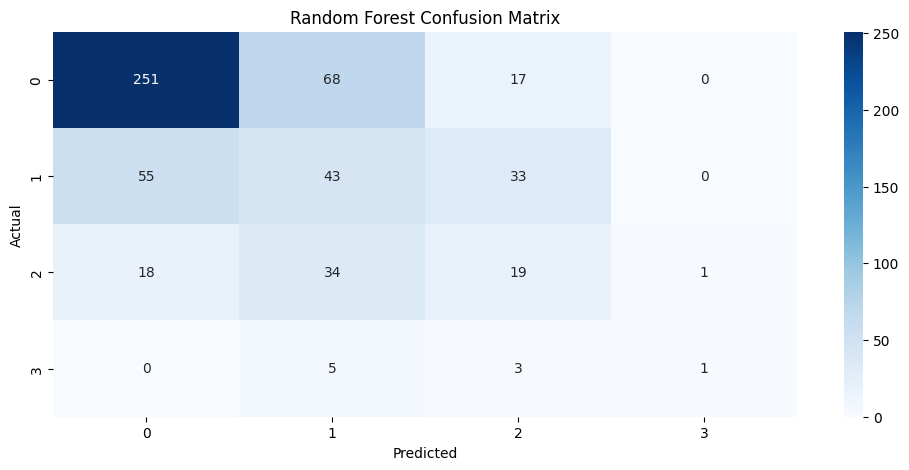

In [17]:
# Best model after hyperparameter tuning
#rf_model_balanced = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=4, min_samples_leaf=1, random_state=42, class_weight='balanced')

rf_model_balanced = rf_random.best_estimator_

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model_balanced, X_train_selected, y_train, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Accuracy Scores:", rf_cv_scores)
print("Random Forest Mean Cross-Validation Accuracy:", np.mean(rf_cv_scores))

# Fit the Random Forest model
rf_model_balanced.fit(X_train_selected, y_train)

# Make predictions on the test set
rf_predictions = rf_model_balanced.predict(X_test_selected)

# Evaluate the models using the test set
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Plot Confusion Matrices for Test Set
plt.figure(figsize=(12, 5))

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END learning_rate=0.3, max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=  43.6s
[CV] END learning_rate=0.3, max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=  44.5s
[CV] END learning_rate=0.3, max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=  48.2s
[CV] END learning_rate=0.3, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time=  54.9s
[CV] END learning_rate=0.3, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time=  57.6s
[CV] END learning_rate=0.3, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time= 1.0min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.8; total time= 2.2min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf

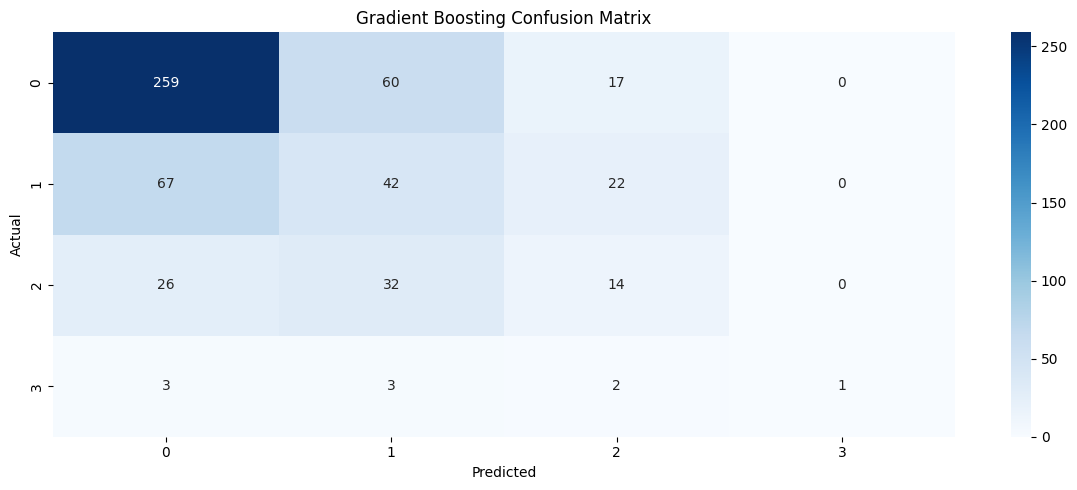

In [18]:
# Step 8: Modeling with Random Forest and Gradient Boosting (with class weight adjustment)
# Define Random Forest and Gradient Boosting models with class weight adjustment
gb_model_balanced = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb_random_search = RandomizedSearchCV(gb_model_balanced, param_distributions=param_grid_gb, n_iter=10, cv=3, random_state=42, n_jobs=-1, scoring='accuracy', verbose = 2)
gb_random_search.fit(X_train_selected, y_train)

print(gb_random_search.best_estimator_)

# Best model after hyperparameter tuning
gb_model_balanced = gb_random_search.best_estimator_

# Cross-validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model_balanced, X_train_selected, y_train, cv=5, scoring='accuracy')
print("\nGradient Boosting Cross-Validation Accuracy Scores:", gb_cv_scores)
print("Gradient Boosting Mean Cross-Validation Accuracy:", np.mean(gb_cv_scores))

# Fit the Gradient Boosting model
gb_model_balanced.fit(X_train_selected, y_train)

# Make predictions on the test set
gb_predictions = gb_model_balanced.predict(X_test_selected)

# Evaluate the models using the test set
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, gb_predictions))

# Plot Confusion Matrices for Test Set
plt.figure(figsize=(12, 5))

# Gradient Boosting Confusion Matrix
sns.heatmap(confusion_matrix(y_test, gb_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### Best Parameters Gradient Boosting
#GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_leaf=4,
#                           min_samples_split=10, n_estimators=200,
#                           random_state=42, subsample=0.8)

In [19]:
# Make predictions on the test set
rf_predictions = rf_model_balanced.predict(test_data[selected_features])
gb_predictions = gb_model_balanced.predict(test_data[selected_features])

# Evaluate the models using the test set
rf_siis = rf_predictions.tolist()
gb_siis = gb_predictions.tolist()

print(f"The random forest siis are {rf_siis}")
print(f"The gradient boost siis are {gb_siis}")

#### Previous predictions
#The random forest siis are [2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0]
#The gradient boost siis are [2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0]

The random forest siis are [2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0]
The gradient boost siis are [2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0]


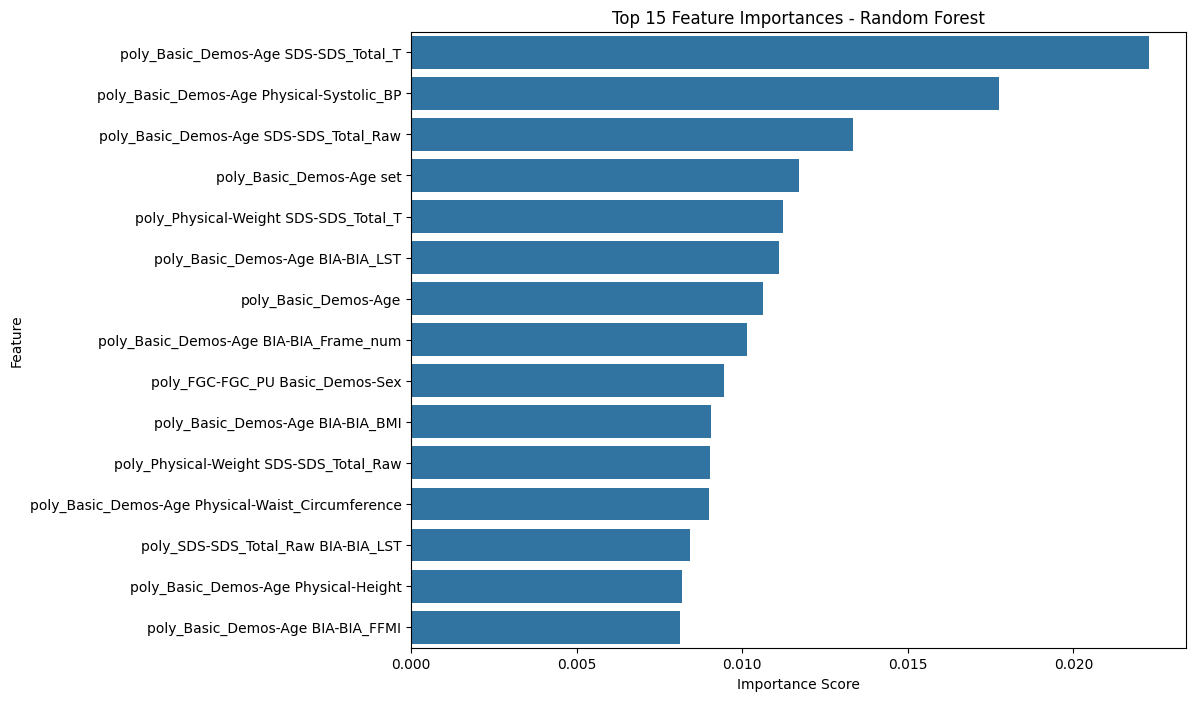

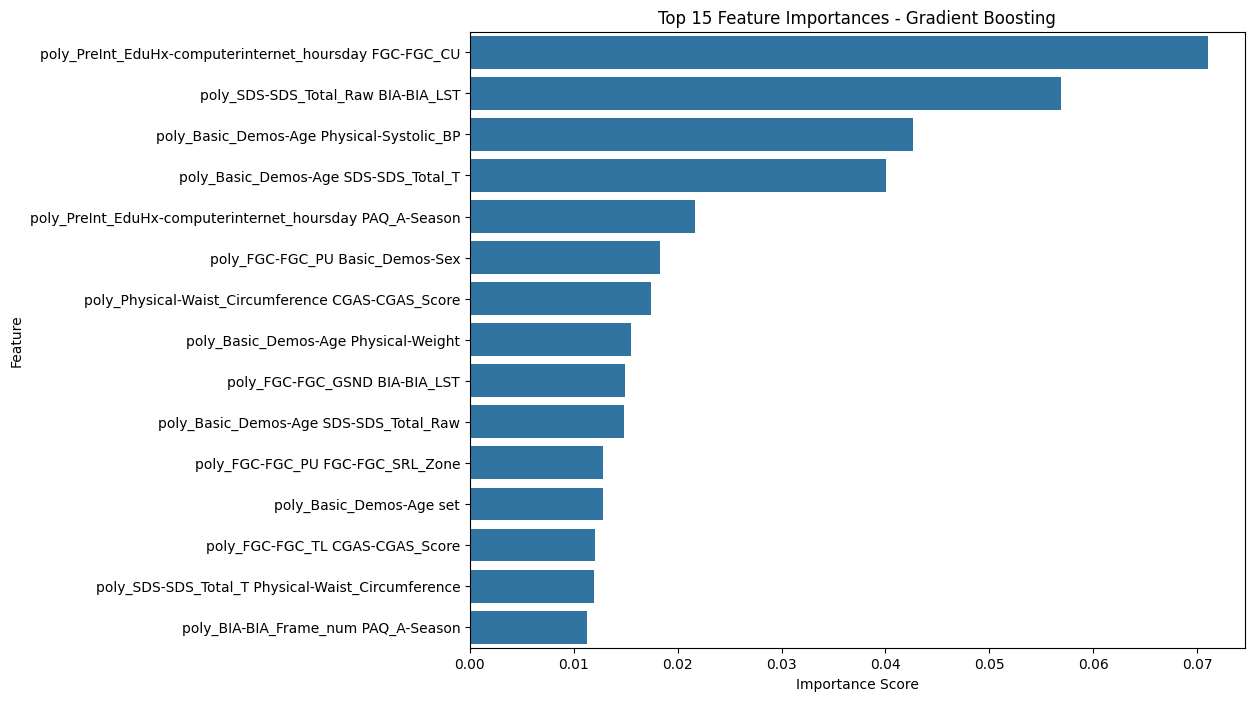

In [20]:
# Step 9: Feature Importance Visualization
# Get feature importances from the trained Random Forest and Gradient Boosting models
importances_rf = rf_model_balanced.feature_importances_
importances_gb = gb_model_balanced.feature_importances_

# Creating a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'RandomForest Importance': importances_rf,
    'GradientBoosting Importance': importances_gb
})

# Sorting the features by importance for RandomForest
feature_importance_df_sorted_rf = feature_importance_df.sort_values(by='RandomForest Importance', ascending=False)

# Plotting feature importance for RandomForest
plt.figure(figsize=(10, 8))
sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_df_sorted_rf.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Sorting the features by importance for Gradient Boosting
feature_importance_df_sorted_gb = feature_importance_df.sort_values(by='GradientBoosting Importance', ascending=False)

# Plotting feature importance for Gradient Boosting
plt.figure(figsize=(10, 8))
sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_df_sorted_gb.head(15))
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
